In [76]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool, metrics, cv

import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [77]:
def result_pred(pred, resY):
    print(f'mean_squared_error: {math.sqrt(mean_squared_error(resY, pred))}')
    print(f'mean_absolute_error: {mean_absolute_error(resY, pred)}')
    print(f'median_absolute_error: {median_absolute_error(resY, pred)}')
    print(f'r2_score: {r2_score(resY, pred)}')


def result_value(pred, resY):
    return [math.sqrt(mean_squared_error(resY, pred)),
            mean_absolute_error(resY, pred),
            median_absolute_error(resY, pred),
            r2_score(resY, pred)]


def result_table(args, resY, subcol=None, valueSubCol=None):
    if subcol and valueSubCol:
        dt = {subcol: valueSubCol,
            'mean_squared_error': [],
            'mean_absolute_error': [],
            'median_absolute_error': [],
            'r2_score': []}
    else:
        dt = {'mean_squared_error': [],
            'mean_absolute_error': [],
            'median_absolute_error': [],
            'r2_score': []}
    preds = args
    for pred in preds:
        tmp = result_value(pred, resY)
        dt['mean_squared_error'].append(tmp[0])
        dt['mean_absolute_error'].append(tmp[1])
        dt['median_absolute_error'].append(tmp[2])
        dt['r2_score'].append(tmp[3])
    return dt

In [78]:
data = pd.read_csv('TrainTestDATA.csv').iloc[:, 1:]

In [79]:
data = data.drop(columns=['model'])

In [80]:
data

,price,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand,notRepairedDamage
0,4450,limousine,2003,manual,150,150000,diesel,bmw,no
1,13299,suv,2005,manual,163,150000,diesel,volvo,no
2,3200,bus,2003,manual,101,150000,diesel,volkswagen,no
3,4500,small car,2006,manual,86,60000,petrol,seat,no
4,18750,suv,2008,automatic,185,150000,diesel,volvo,no
...,...,...,...,...,...,...,...,...,...
41770,790,limousine,1998,manual,82,150000,diesel,opel,no
41771,830,small car,1999,manual,60,125000,petrol,renault,no
41772,175000,coupe,1998,manual,286,50000,petrol,porsche,no
41773,2290,station wagon,2001,manual,101,150000,petrol,opel,no


In [81]:
data.to_csv('TrainTestDATA_Second.csv')

## **Работа с категориальными признаками**

In [82]:
data = pd.get_dummies(data, columns=['vehicleType'])
data = pd.get_dummies(data, columns=['gearbox'])
data = pd.get_dummies(data, columns=['fuelType'])

data['brand'] = data['brand'].astype('category')
data['brand'] = data['brand'].cat.codes

data['notRepairedDamage'] = data['notRepairedDamage'].astype('category')
data['notRepairedDamage'] = data['notRepairedDamage'].cat.codes

for elem in data.iloc[:, :]:
    data[elem] = data[elem].map(int)

## **Посмотрим на получившиеся данные и построим матрицу корреляции**

In [83]:
data

,price,yearOfRegistration,powerPS,kilometer,brand,notRepairedDamage,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_limousine,...,vehicleType_station wagon,vehicleType_suv,gearbox_automatic,gearbox_manual,fuelType_cng,fuelType_diesel,fuelType_electro,fuelType_hybrid,fuelType_lpg,fuelType_petrol
0,4450,2003,150,150000,2,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,13299,2005,163,150000,38,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
2,3200,2003,101,150000,37,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,4500,2006,86,60000,30,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,18750,2008,185,150000,38,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41770,790,1998,82,150000,24,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
41771,830,1999,60,125000,27,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
41772,175000,1998,286,50000,26,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
41773,2290,2001,101,150000,24,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


<Axes: >

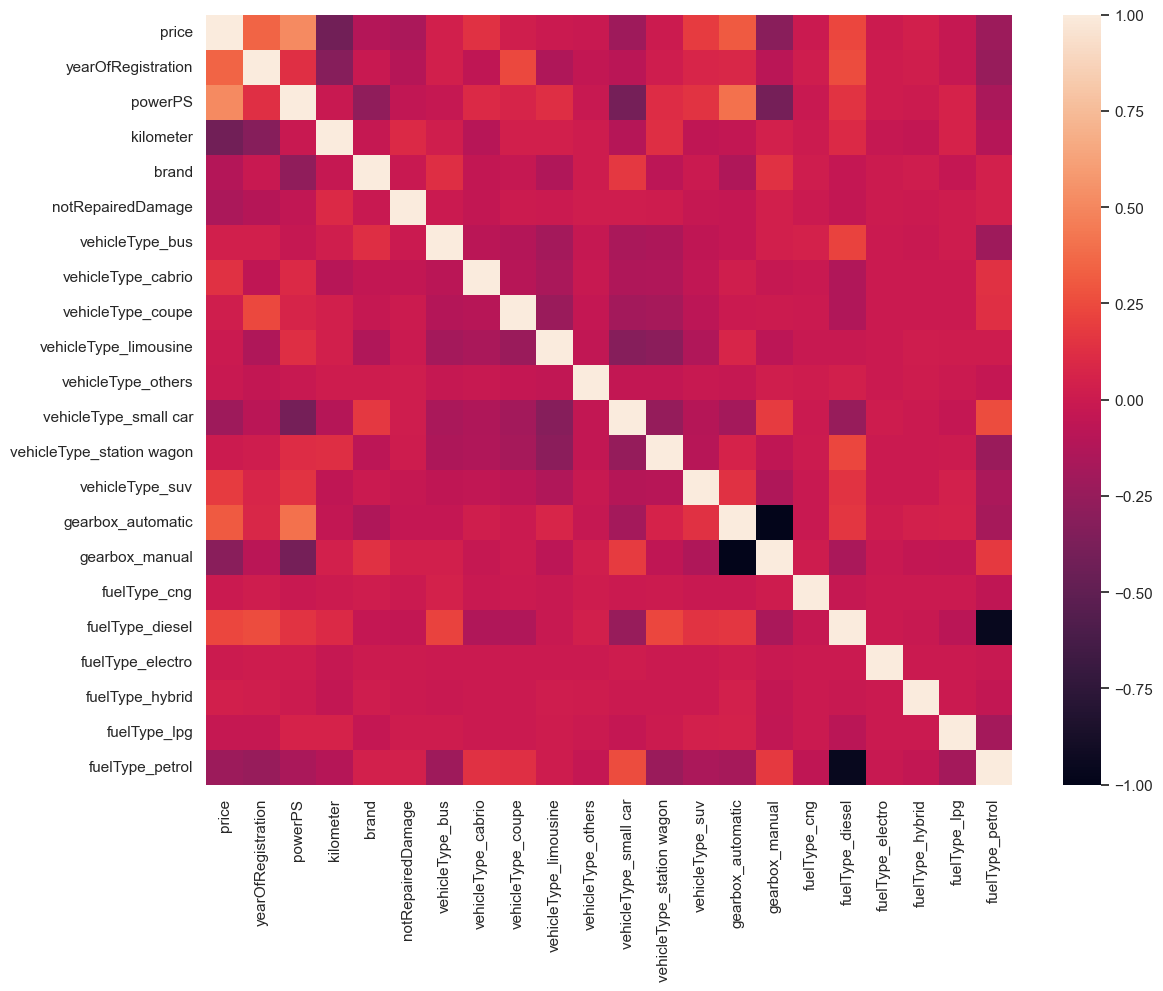

In [84]:
corr_matrix = data.corr()

sns.set(rc={'figure.figsize': (13, 10)})

sns.heatmap(corr_matrix, annot=False)

## **Разделим данные**

In [89]:
X = data.drop(columns=['price'])
Y = data['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

## **По подбираем более точные параметры для CatboostRegressor**

In [103]:
model_search_CBR = CatBoostRegressor(iterations=10001,
                                     rsm=1,
                                     early_stopping_rounds=100,
                                     grow_policy='Depthwise',
                                     depth=7,
                                     loss_function='RMSE',
                                     eval_metric='RMSE',
                                     l2_leaf_reg=20,
                                     learning_rate=0.1,
                                     border_count=500,
                                     verbose=1000,
                                     task_type='GPU'
                                     )

model_search_CBR.fit(X_train, Y_train)

pred_model_search_CBR = model_search_CBR.predict(X_test)

0:	learn: 7262.8559795	total: 9.08ms	remaining: 1m 30s
1000:	learn: 1744.9912068	total: 4.7s	remaining: 42.2s
2000:	learn: 1469.9031312	total: 9.68s	remaining: 38.7s
3000:	learn: 1344.8015676	total: 15.2s	remaining: 35.4s
4000:	learn: 1273.7832594	total: 21.8s	remaining: 32.6s
5000:	learn: 1228.2938235	total: 28.4s	remaining: 28.4s
6000:	learn: 1196.2589799	total: 35s	remaining: 23.3s
7000:	learn: 1173.1975571	total: 41.6s	remaining: 17.8s
8000:	learn: 1155.1489030	total: 48.4s	remaining: 12.1s
9000:	learn: 1140.7676108	total: 55.1s	remaining: 6.12s
10000:	learn: 1128.5197067	total: 1m	remaining: 0us


In [104]:
result_pred(pred_model_search_CBR, Y_test)

mean_squared_error: 2302.031363442505
mean_absolute_error: 1265.0972002131173
median_absolute_error: 657.1924831866952
r2_score: 0.881532843163671


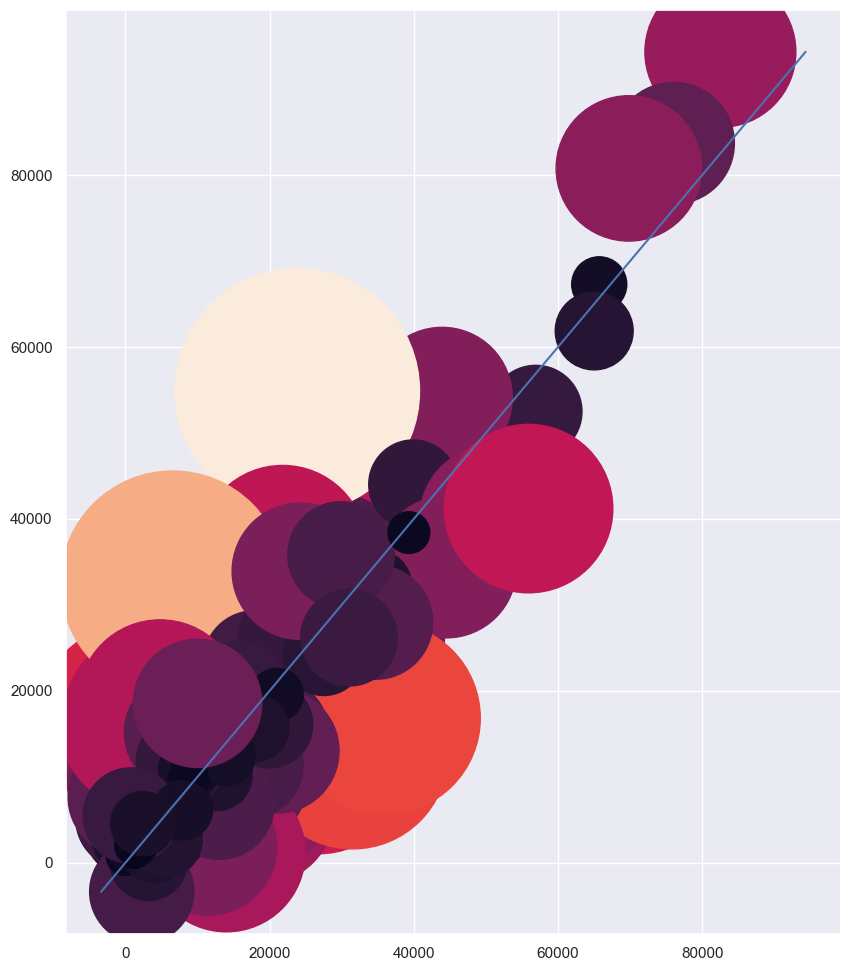

In [105]:
test_predictions = np.array(pred_model_search_CBR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [106]:
model_search_CBR.fit(X, Y)

0:	learn: 7160.0494575	total: 8.53ms	remaining: 1m 25s
1000:	learn: 1750.1540216	total: 4.6s	remaining: 41.4s
2000:	learn: 1479.3863378	total: 9.73s	remaining: 38.9s
3000:	learn: 1357.4900992	total: 15.1s	remaining: 35.2s
4000:	learn: 1286.5760651	total: 20.1s	remaining: 30.2s
5000:	learn: 1240.6900909	total: 25.5s	remaining: 25.5s
6000:	learn: 1208.3815647	total: 31.2s	remaining: 20.8s
7000:	learn: 1183.9903627	total: 38.3s	remaining: 16.4s
8000:	learn: 1164.9302562	total: 45.5s	remaining: 11.4s
9000:	learn: 1149.6523455	total: 52.7s	remaining: 5.86s
10000:	learn: 1137.4909497	total: 1m	remaining: 0us


In [107]:
result_pred(model_search_CBR.predict(X), Y)

mean_squared_error: 1137.490662728777
mean_absolute_error: 650.0305173863663
median_absolute_error: 406.0076100691449
r2_score: 0.9776437123045337


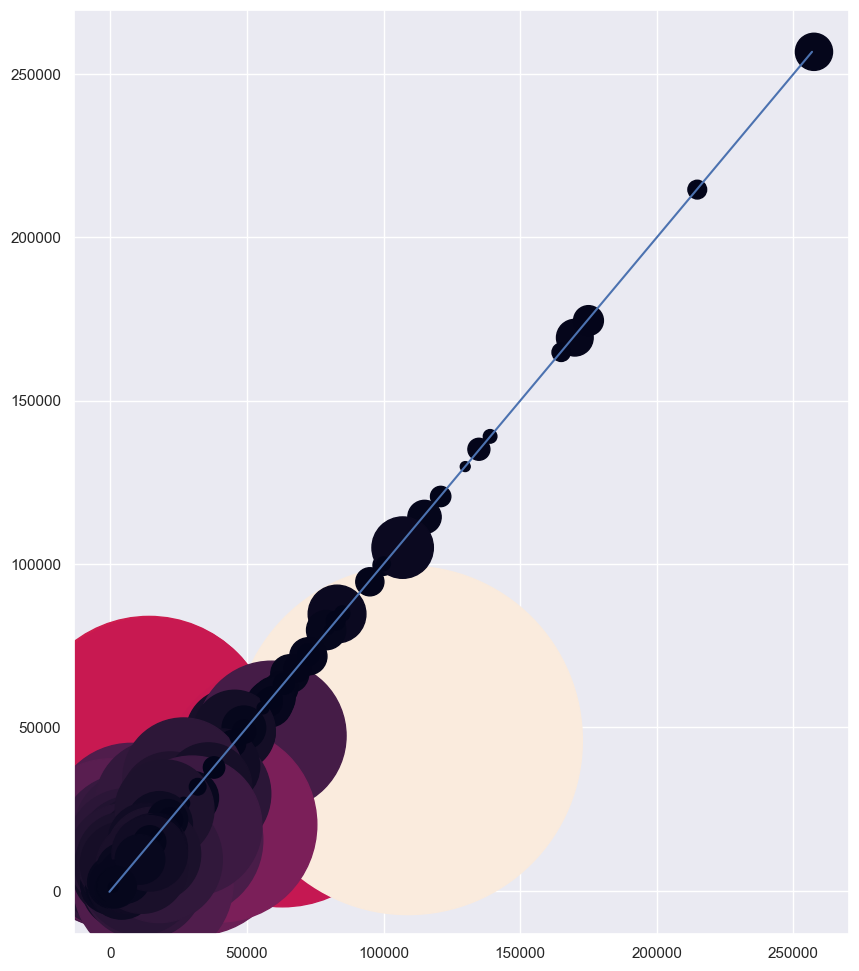

In [108]:
test_predictions = np.array(model_search_CBR.predict(X))
area = abs(Y - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y, test_predictions, marker='o', s=area, c=area)

## **Сохраним модель**

In [109]:
with open('bestModelFourth.bf', '+wb') as bestModel:
    pickle.dump(model_search_CBR, bestModel)